In [23]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display
import visuals as vs

%matplotlib inline

data = pd.read_csv("census.csv")
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


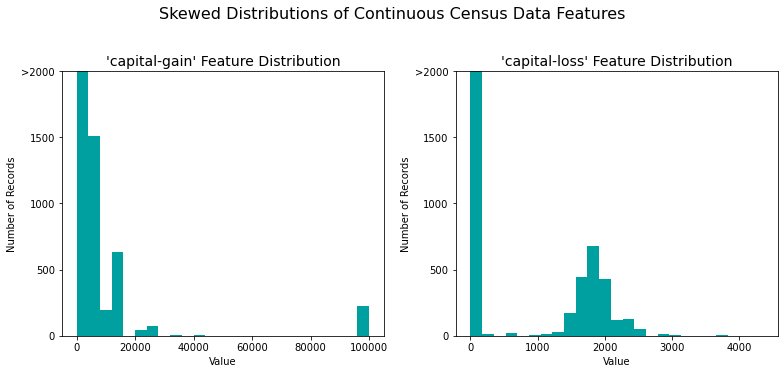

In [24]:
# 去掉income 为后续做准备
income_raw = data['income']
features_raw = data.drop('income', axis = 1)
# 观察数据偏差大
vs.distribution(features_raw)

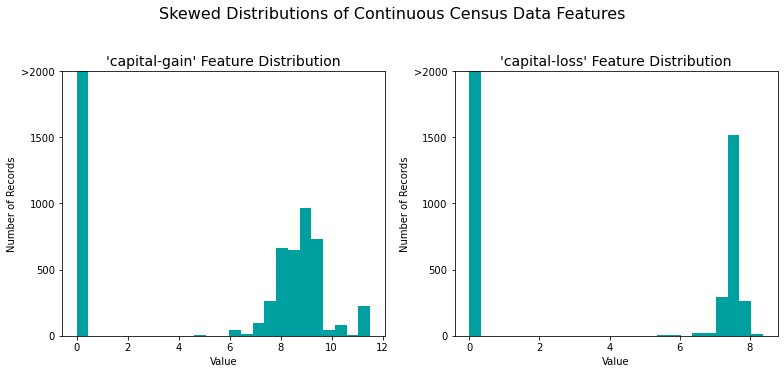

In [25]:
# 对于高度偏差的特征分布，应用对数变换是很常见的做法
# 但是，在应用这种转换时必须注意：0的对数是未定义的，因此我们必须将数值转换成大于0的值。
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x:np.log(x+1))
vs.distribution(features_log_transformed)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


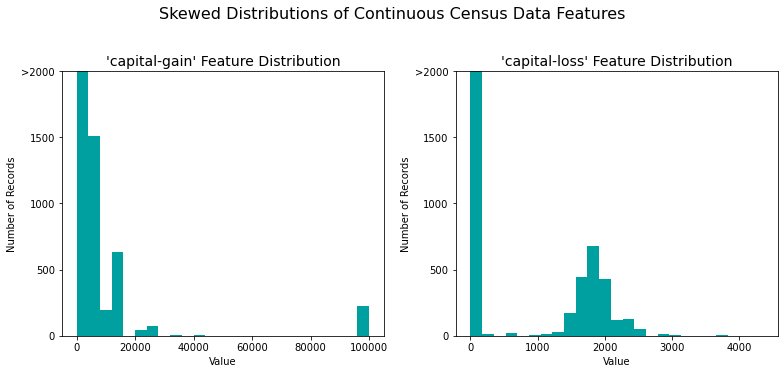

In [26]:
# 归一化(正则化)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_log_minmax_transfrom = pd.DataFrame(data=features_log_transformed)
features_log_minmax_transfrom[numerical] = scaler.fit_transform(features_log_minmax_transfrom[numerical])

display(features_log_minmax_transfrom.head(n=5))
vs.distribution(data)

In [27]:
from sklearn.preprocessing import LabelEncoder
# one-hot化
features_final = pd.get_dummies(features_log_minmax_transfrom)

# display(features_final.head(n=5))
# income 特征化
encoder = LabelEncoder()
income = encoder.fit_transform(income_raw)

encoded = list(features_final.columns)
# encoded
print("{} total features after one-hot encoding.".format(len(encoded)))


# pd.get_dummies(income_raw)



103 total features after one-hot encoding.


In [28]:
# 数据集划分
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = 0.2, random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


In [29]:
# Exercise 2 朴素分类器
FP = np.sum(income)
TP = len(income) - FP

accuracy = np.true_divide(TP, TP + FP)
recall = 1
precision = accuracy

fscore = (1 + 0.5**2) * (precision * recall) / ((0.5**2 * precision) + recall)
# Print the results 
print("['accuracy' score: {:.4f}, f-score: {:.4f}]".format(accuracy, fscore))

['accuracy' score: 0.7522, f-score: 0.7914]


In [30]:
##  Exercise 3
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

Gausian = GaussianNB()
DecisionTree = DecisionTreeClassifier(random_state=0)
RandomForest = RandomForestClassifier()

# 模型训练
for clf in [Gausian, DecisionTree, RandomForest]:
    clf.fit(X_train, y_train)


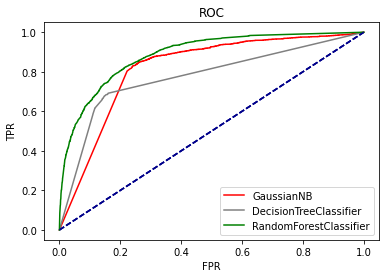

In [31]:
color = ['r','gray','g']
i = 0 
for model in [Gausian, DecisionTree, RandomForest]:
    # 预测
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    fpr, tpr, th = roc_curve(y_test, probs)

    # 绘图
    plt.plot(fpr,tpr,color=color[i], label = model.__class__.__name__)
    i = i+1
    plt.plot([0,1],[0,1],color='darkblue', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    
plt.legend()
plt.show()


## (1) importance of features according to the chosen classifier

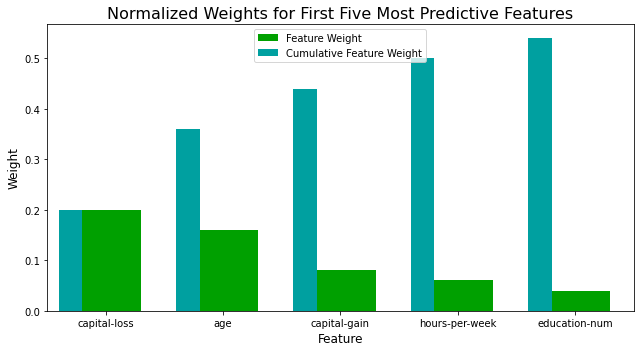

In [32]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(X_train, y_train)
importances = model.feature_importances_

vs.feature_plot(importances, X_train, y_train)

## (2) Describe one real-world application in industry where the model can be applied

### 金融公司根据特征预测用户的收入，并推送相关的金融产品

## (3)What are the strengths of the model; when does it perform well?
## (4)What are the weaknesses of the model; when does it perform poorly
### 先来分析运行时间，很明显SVC无论在测试集还是在训练集都是非常消耗时间的，所以SVC对训练集数据规模比较敏感。准确率上，首先，在训练集，无论数据规模大小，决策树性能优于SVC优于朴素贝叶斯且均优于我们的朴素分类器。然后在测试集上，SVC的性能表现超越了决策树，这也是之前在模型选择时我们提到的，决策树容易产生过拟合，而svc的泛化能力较强。

## (5)What makes this model a good candidate for the problem, given what you know about the data?
### 数据规模，模型训练耗时，模型预测准确率